In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
from genutil import statistics


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one

    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)
    T2 = getfld (g2, vname)
#    print "T2 info ", T2.info()
#    print "T0 info ", T0.info()


    DT2 = T2 - T0
    DT1 = T1 - T0
    
    
    cor02 = statistics.correlation(T2, T0, axis='yx')
#    print "cor02 noweights", cor02
#    cor02 = statistics.correlation(T2, T0, axis='yx',weights='generate')
#    print "cor02 generated", cor02
    cor01 = statistics.correlation(T1, T0, axis='yx')
    rms02 = statistics.rms(T2, T0, axis='yx')
#    print "rms noweights", rms02
#    rms02 = statistics.rms(T2, T0, axis='yx',weights='generate')
#    print "rms generated", rms02
    rms01 = statistics.rms(T1, T0, axis='yx')
    print "rms (uncentered, biased) rms02, rms01", rms02, rms01
    print "corr (centered, biased) cor02, cor01", cor02, cor01

    DT1.rms = rms01
    DT2.rms = rms02
    DT1.cor = cor01
    DT2.cor = cor02
  
    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
def setup3 ():
    fig = plt.figure(figsize=(6, 9)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    ax1 = plt.subplot(gs[2],projection=ccrs.Robinson())
    ax1.set_global() # make axis consistent with projection limits
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.Robinson())
    ax2.set_global() # make axis consistent with projection limits
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#       print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
#    print "data range",data.min(), data.max()
#    print "clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
    print"pltframe done"

def pltdat(TP0, TP1, TP2):
    cmap = plt.cm.viridis
    lons = TP0.getLongitude()
    lats = TP0.getLatitude()
    ltit0 = "ltit0"
    #dlevs = [-20.,-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.,20.]
    # find decent contour levels that are common to the first two fields
    crange = np.array([TP0.min(),TP1.min(),TP0.max(), TP1.max()])
    print "crange", crange
    clevs = pjr.findNiceContours(crange,20)
    print "clevs", clevs
#   #print TP0.info()
    print "TP0 G Avg", cdutil.averager(TP0,axis="xy")
    pltframe(TP0, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':TP0.long_name,'rtitle':ltit0,'clevs':clevs,'cbel':'grey','cabv':'orange'})
    
#    rtit1 = "RMS/CC %7.2g"%DT1.rms+"/%3.2f"%DT1.cor # DT1xav.cor
    rtit1 = "rtit1"
#   rtit2 = "RMS/CC %7.2g"%DT2.rms+"/%3.2f"%DT2.cor# 
    rtit2 = "rtit2"
    print "TP1 G Avg", cdutil.averager(TP1,axis="xy")
    pltframe(TP1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'rtitle':rtit2,'ltitle':ltit2,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})


    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(TP2,20,sym=True,rmClev=0.)
    print "dlevs", dlevs
    print "TP2 G Avg", cdutil.averager(TP2,axis="xy")
    pltframe(TP2, lons, lats, ax3[2], cx3[2], 
             plotOpt={'rtitle':rtit1,'ltitle':ltit1,'cmap':cmap,'clevs':dlevs,'cbel':'grey','cabv':'magenta'})


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
seas JJA
jname1 /Users/d3x345/Netcdf_Files/vd05_JJA_climo.nc
jname2 /Users/d3x345/Netcdf_Files/vd05_JJA_climo.nc
i QFLX
crange [-16.01888  -16.158583 403.41605  415.27808 ]
clevs [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400.]
TP0 G Avg 92.58685726919838
pltframe
pltframe done
TP1 G Avg 94.54970343889879
pltframe
pltframe done
dlevs [-11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.  11.]
TP2 G Avg -1.962846169700872
pltframe
pltframe done
SST range 198.72827 313.01562
LHFLX range -16.158583 415.27808
LHFL3 range -16.01888 403.41605
DF range -11.86203 0.8212261
figur

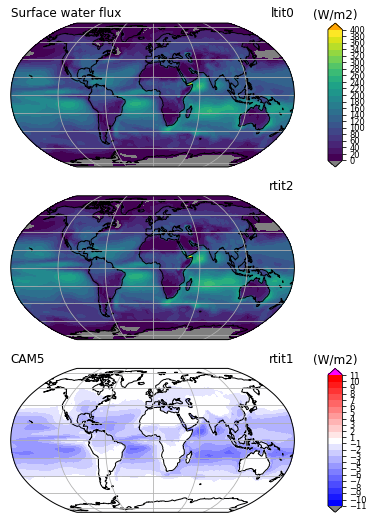

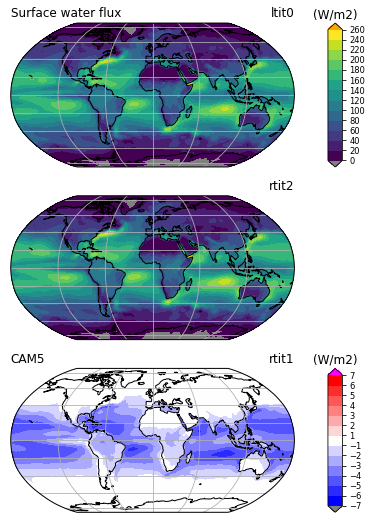

In [6]:
#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# identify the levels that we will interpolate to
levs = pjr.findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("QFLX"))

seaslist = ["JJA","ANN"]

for seas in seaslist:
    print "seas", seas

    # observations
    #jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
    #ltit0 = seas+" MERRA2"
    #print "jname0", jname0

    # model1 dataset
    dir1 = "/Users/d3x345/Netcdf_Files/"
    f1 = "vd05_"+seas+"_climo.nc"
    ltit1 = "CAM5"
    jname1 = dir1+f1
    print "jname1", jname1

    # model2 dataset
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    ltit2 = ""
    jname2 = dir2+f2
    jname2 = jname1
    print "jname2", jname2  


    #g0 = cdms2.open(jname0);
    #varlist = g0.listvariables();
    #print "obs varlist", varlist
    #dims = g0.listdimension();
    g1 = cdms2.open(jname1);
    g2 = cdms2.open(jname2)

    fig, ax3, cx3 = setup3()
    for i in vlist:
        print "i", i.name
        vname = i.name
        pltname = "Roblatlon_"+i.name+"_"+seas+"_test.pdf"
        QFLX = getfld (g1, "QFLX")
        SST = getfld(g1,"TS")
        LHFLX = getfld(g1,"LHFLX")
        LHVAP = 2.501E6
        LHFL2 = QFLX*LHVAP
        LHFL2.units = "W/m2"
        T0 = 273.16
        CPLIQ = 4220. # J/Kg/K @ T0 
        CPVAP = 1870. # J/Kg/K @ T0
        L0 = 2.501e6 # J/Kg @T0
        LHFL3 = L0 + (CPVAP-CPLIQ)*(SST-T0)
        #LHFL3 = LHFL3/L0
        LHFL3 = QFLX*LHFL3
        LHFL3.units = "W/m2"
        LHFL3.name = "LHFLX_T"
        LHFL3.longname = "Latent Heat Flux (T dependent)"
        DF = LHFL3 - LHFLX
        pltdat(LHFL3, LHFLX, DF)
        #pltdat(LHFLX, LHFL3, LHFL3)
        print "SST range", SST.min(), SST.max()
        print "LHFLX range", LHFLX.min(), LHFLX.max()
        print "LHFL3 range", LHFL3.min(), LHFL3.max()
        print "DF range", DF.min(), DF.max()
        #TP0, DT1, DT2 = getdat(g0, i.oname, g1, g2, i.mname)
        #pltdat(LHFLX, LHFL3, DF)
        print "figure being saved to ", pltname
        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        print "done with"+i.name
    # break
